In [28]:

from matplotlib import pyplot as plt
import os
import numpy as np
import glob
import os

## astropy
import astropy.units as u
from astropy.table import Table

## calin
from cta.nectarcam.feb.I_NmcConfig import NmcConfig

## ctapipe
from ctapipe_io_nectarcam import NectarCAMEventSource 
from ctapipe.io import event_source, EventSeeker

import scipy.stats as scsp
from scipy.stats import poisson                                                                                                             

from fit_ses_v6 import *
#import seaborn as sns
from astropy.io import ascii 



In [2]:
plt.rcParams['figure.figsize'] = [15, 7]

In [3]:
data_file_paths = ["/media/ttaverni/Transcend/data/lintest/NectarCAM.Run1879.000[0-9].fits.fz", \
                   "/media/ttaverni/Transcend/data/lintest/NectarCAM.Run1877.000[0-9].fits.fz", \
                   "/media/ttaverni/Transcend/data/lintest/NectarCAM.Run1876.000[0-9].fits.fz", \
                   "/media/ttaverni/Transcend/data/lintest/NectarCAM.Run1875.000[0-9].fits.fz", \
                   "/media/ttaverni/Transcend/data/lintest/NectarCAM.Run1874.000[0-9].fits.fz", \
                   "/media/ttaverni/Transcend/data/lintest/NectarCAM.Run1873.000[0-9].fits.fz", \
                   "/media/ttaverni/Transcend/data/lintest/NectarCAM.Run1872.000[0-9].fits.fz", \
                   "/media/ttaverni/Transcend/data/lintest/NectarCAM.Run1871.000[0-9].fits.fz", \
                   "/media/ttaverni/Transcend/data/lintest/NectarCAM.Run1870.000[0-9].fits.fz", \
                   "/media/ttaverni/Transcend/data/lintest/NectarCAM.Run1869.000[0-9].fits.fz", \
                   "/media/ttaverni/Transcend/data/lintest/NectarCAM.Run1868.000[0-9].fits.fz", \
                   "/media/ttaverni/Transcend/data/lintest/NectarCAM.Run1867.000[0-9].fits.fz", \
                   "/media/ttaverni/Transcend/data/lintest/NectarCAM.Run1880.000[0-9].fits.fz"]
densities = np.array([2.59,2.25,1.90,1.83,1.63,1.42,1.22,0.89,0.69,0.55,0.35,0.20,0])

In [4]:

        data_file_path = "/media/ttaverni/Transcend/data/lintest/NectarCAM.Run1866.000[0-9].fits.fz"
        inputfile_reader = NectarCAMEventSource(
            input_url = data_file_path,
            max_events=2000)

        cfg = inputfile_reader.camera_config
        pix_ids = cfg.expected_pixels_id[:]
        all_wfs = []
        for ii, event in enumerate(inputfile_reader):
            #print(event.r0.tel[0].trigger_type)
            all_wfs.append(event.r0.tel[event.r0.tels_with_data[0]].waveform[:,pix_ids])
        pedestals = np.array(all_wfs).mean(axis=0)
all_wfs=[]

In [5]:
#        data_file_path = "/media/ttaverni/Transcend/data/lintest/NectarCAM.Run1880.000[0-9].fits.fz"
#        inputfile_reader = NectarCAMEventSource(
#            input_url = data_file_path,
#            max_events=2000)
#        Q_LG =[]
#        cfg = inputfile_reader.camera_config
#        pix_ids = cfg.expected_pixels_id[:]
#        all_wfs = []
#        for ii, event in enumerate(inputfile_reader):
#            wfs = event.r0.tel[event.r0.tels_with_data[0]].waveform[:,pix_ids]
#            Q_LG.append( (wfs[1,:,m-wfst:m+wfen]-pedestals[1,:,m-wfst:m+wfen]).sum(axis=1) /58. *13.5)
#        np.mean(Q_LG)

In [6]:
pedestals.shape

(2, 371, 60)

In [87]:
Qs_HGm = []
Qs_LGm = []

Qs_HGstd = []
Qs_LGstd = []

Qs_LGcorstd= []

sattest =[]
wfst=6
wfen=10
m = 20
#As_HG = []
#As_LG = []
## Iref 
Ir = 70.706
I0 = Ir*10**densities[5]
maxevt = 1000
for jj,data_file_path in enumerate(data_file_paths):
        TrueI = I0/10**densities[jj]
        
        Q_HG = []
        Q_LG = []
        tmpsat = []
        inputfile_reader = NectarCAMEventSource(
            input_url = data_file_path,
            max_events=maxevt)

        cfg = inputfile_reader.camera_config
        pix_ids = cfg.expected_pixels_id[:]
        for ii, event in enumerate(inputfile_reader):
            #print(event.r0.tel[0].trigger_type)
            wfs = event.r0.tel[event.r0.tels_with_data[0]].waveform[:,pix_ids]
            Q_HG.append( (wfs[0,:,m-wfst:m+wfen]-pedestals[0,:,m-wfst:m+wfen]).sum(axis=1) /58. )
            Q_LG.append( (wfs[1,:,m-wfst:m+wfen]-pedestals[1,:,m-wfst:m+wfen]).sum(axis=1) /58. *13.5)
            tmpsat.append((wfs[0]==4095).sum())
            #Q_HG.append( (wfs[0,:,m-wfst:m+wfen].T-wfs[0,:,0:10].mean(axis=1)).sum(axis=0) /58. )
            #Q_LG.append( (wfs[1,:,m-wfst:m+wfen].T-wfs[0,:,0:10].mean(axis=1)).sum(axis=0) /58. *13.5)
        Qs_HGm.append(np.array(Q_HG).mean(axis=0))
        Qs_LGm.append(np.array(Q_LG).mean(axis=0))
        Qs_HGstd.append(((np.array(Q_HG) - TrueI)**2).sum(axis=0)**.5 /maxevt**.5)
        Qs_LGstd.append(((np.array(Q_LG) - TrueI)**2).sum(axis=0)**.5 /maxevt**.5)
        
        Qs_LGcorstd.append(((np.array(Q_LG)**0.888*1.57 - TrueI)**2).sum(axis=0)**.5 /maxevt**.5)
        #Qs_LGcorstd.append(((np.array(Q_LG)**0.8924849 * 1.51547261+3.5740729 - TrueI)**2).sum(axis=0)**.5 /maxevt**.5)
        sattest.append(np.mean(tmpsat))
        
Qs_HGm = np.array(Qs_HGm)
Qs_LGm = np.array(Qs_LGm)
Qs_HGstd = np.array(Qs_HGstd)
Qs_LGstd = np.array(Qs_LGstd)
Qs_LGcorstd = np.array(Qs_LGcorstd)

/local/home/ttaverni/anaconda3/envs/nectarchain-dev/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in power


In [8]:
#I0 = 2885.0
nir = 5
Ir = Qs_HGm.mean(axis=1)[nir]
I0 = Ir*10**densities[nir]
#I0 = Qs_LGm.mean(axis=1)[-1]
Is = I0/10**densities

In [12]:
Ir

70.70686223162005

array([1.57251338, 0.88803268])

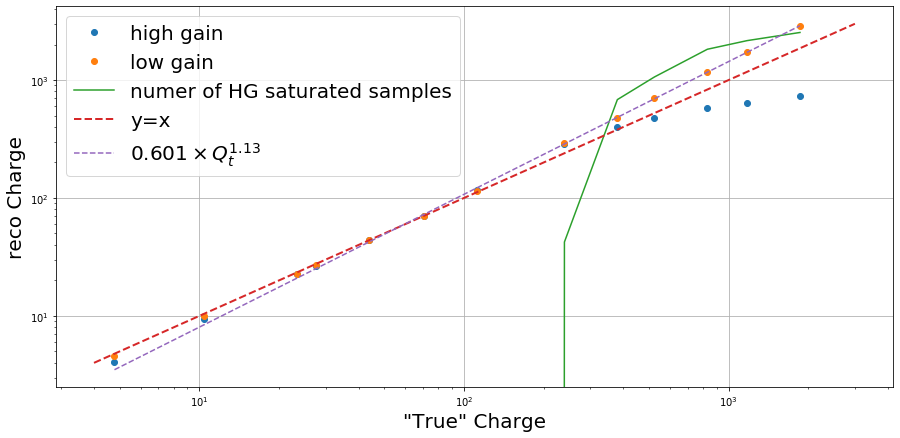

In [89]:
plt.plot(Is,Qs_HGm.mean(axis=1),'o',label='high gain')
plt.plot(Is,Qs_LGm.mean(axis=1),'o',label='low gain')
plt.plot(Is,sattest,label='numer of HG saturated samples')
#plt.plot(Is,Qs_LGm,color='black',alpha=.01)
plt.plot(range(4,3000),range(4,3000),'--',lw=2,label='y=x')

def fff(Qt,a,b):
    return a*Qt**b
pp,pcov = curve_fit(fff,Is[5:],Qs_LGm.mean(axis=1)[5:])
plt.plot(Is,fff(Is,*pp),'--',label=r'${:.3} \times Q_t^{{{:.3}}}$'.format(*pp))


plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().legend(prop={'size':20})
plt.gca().set_xlabel('"True" Charge',fontsize=20)
plt.gca().set_ylabel('reco Charge',fontsize=20)
plt.gca().grid()


pp2,pcov = curve_fit(fff,Qs_LGm.mean(axis=1)[5:],Is[5:])
pp2

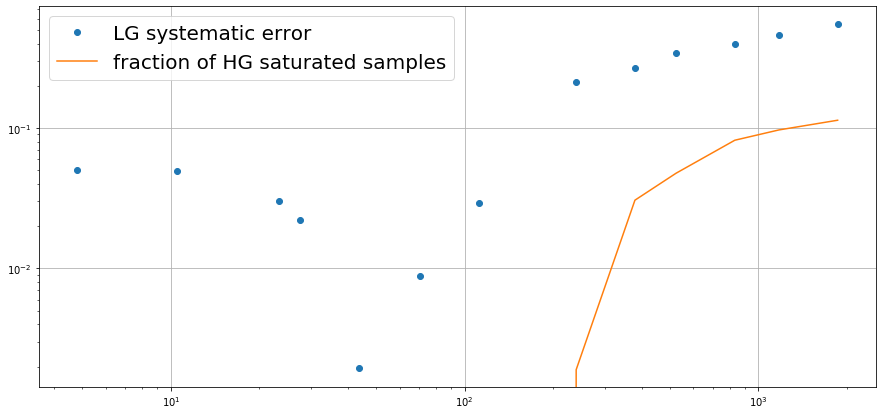

In [107]:
#plt.loglog(Is[:5],abs(Qs_HGm.mean(axis=1)[:5]-Is[:5])/Is[:5],'o',label="HG systematic error")
plt.loglog(Is,abs(Qs_LGm.mean(axis=1)-Is)/Is,'o',label="LG systematic error")

plt.plot(Is,np.array(sattest)/(371*60),label='fraction of HG saturated samples')
plt.gca().grid()
plt.gca().legend(prop={'size':20})


In [11]:
(Qs_LGm.mean(axis=1)-Is)/Is

array([-0.0499856 , -0.04977602, -0.03011717, -0.02221924,  0.00194989,
       -0.00890218,  0.0291418 ,  0.21115333,  0.26606994,  0.34188002,
        0.39858185,  0.46022671,  0.55279356])

In [29]:
    QQ1,logres1 = np.array(ascii.read("./IntensityRes.txt").to_pandas()).T                                                                                                                              
    QQ2,logres2 = np.array(ascii.read("./IntensityResHighNSB.txt").to_pandas()).T                    
    # ~ ax.plot(Q_xx,np.sqrt(1.0+nnsb+1.14**2*Q_xx+0.05**2*Q_xx**2)/Q_xx,'--',linewidth=2,label=r'GOAL',color='orange')
    # ~ ax.plot(Q_xx,np.sqrt(2.0+nnsb+1.18**2*Q_xx+0.10**2*Q_xx**2)/Q_xx,'--',linewidth=2,label=r'requirement',color='r')
    


(0.01, 50)

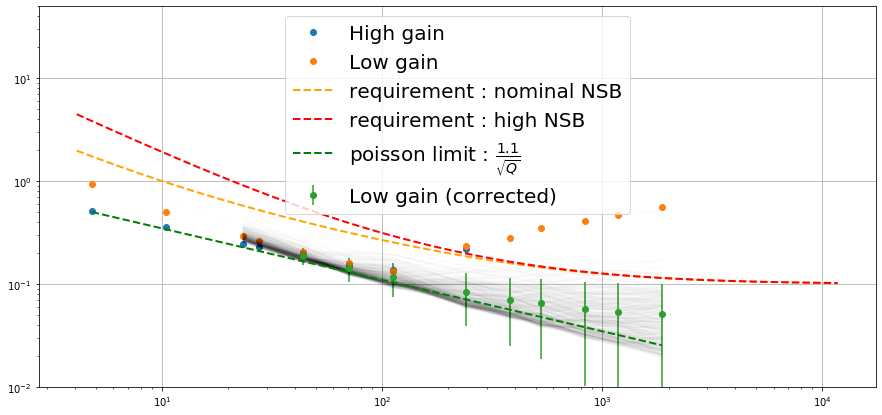

In [101]:

plt.loglog(Is[:8], Qs_HGstd[:8].mean(axis=1)/Is[:8],'o',label="High gain")
plt.loglog(Is, Qs_LGstd.mean(axis=1)/Is,'o',label="Low gain")
plt.loglog(Is, (Qs_LGcorstd.T/Is).T,color='black',alpha =.01)

plt.errorbar(Is, Qs_LGcorstd.mean(axis=1)/Is,yerr=(Qs_LGcorstd.T/Is).std(axis=0),fmt='o',label="Low gain (corrected)")


plt.plot(QQ1,logres1,'--',linewidth=2,label=r'requirement : nominal NSB',color='orange')
plt.plot(QQ2,logres2,'--',linewidth=2,label=r'requirement : high NSB ',color='r')
plt.plot(Is,1.1/Is**.5,'--',linewidth=2,label=r'poisson limit : $\frac{1.1}{\sqrt{Q}}$',color='green')

plt.gca().grid()
#plt.gca().legend(loc='lower right',prop={'size':20})
plt.gca().legend(loc='upper center',prop={'size':20})
plt.gca().set_ylim(1e-2,50)